In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# Load data
data = pd.read_csv('modeling_data.csv')
X = data[['Total.SqFt', 'Category_encoded', 'Year.Built', 'kWh.sqft', 'lat', 'long', 'cluster']].copy()
X['Building.Age'] = 2024 - X['Year.Built']
X.drop(columns=['Year.Built'], inplace=True)
X = X.to_numpy()
y = data['BestTreeSpecies_encoded'].to_numpy()

# Data splitting
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, stratify=y_, random_state=42)

# Use stratified K fold b/c oak imbalance
K = 3
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Param grid
param_grid = {
    'max_depth': [_ for _ in range(1, 10)] + [None],
    'min_samples_split': [_ for _ in range(2, 5)],
    'min_samples_leaf': [_ for _ in range(1, 5)],
    'max_features': [None, 'sqrt', 'log2']
}

# Models
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_ent = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Grid search
grid_search_gini = GridSearchCV(clf_gini, param_grid, cv=skf, scoring='accuracy')
grid_search_ent = GridSearchCV(clf_ent, param_grid, cv=skf, scoring='accuracy')
grid_search_gini.fit(X_train, y_train)
grid_search_ent.fit(X_train, y_train)
print(f'Best params (gini): {grid_search_gini.best_params_}')
print(f'Best params (entropy): {grid_search_ent.best_params_}')
print()

# Best models
best_clf_gini = grid_search_gini.best_estimator_
best_clf_ent = grid_search_ent.best_estimator_

# Eval on train
accuracy_gini_train = accuracy_score(y_train, best_clf_gini.predict(X_train))
accuracy_ent_train = accuracy_score(y_train, best_clf_ent.predict(X_train))
print(f"Training Accuracy for Decision Tree (gini): {accuracy_gini_train * 100:.2f}%")
print(f"Training Accuracy for Decision Tree (entropy): {accuracy_ent_train * 100:.2f}%")
print()

# Eval on val
accuracy_gini_val = accuracy_score(y_val, best_clf_gini.predict(X_val))
accuracy_ent_val = accuracy_score(y_val, best_clf_ent.predict(X_val))
print(f"Validation Accuracy for Decision Tree (gini): {accuracy_gini_val * 100:.2f}%")
print(f"Validation Accuracy for Decision Tree (entropy): {accuracy_ent_val * 100:.2f}%")
print()

# Eval on test
y_pred_test_gini = best_clf_gini.predict(X_test)
y_pred_test_ent = best_clf_ent.predict(X_test)
print(f"Test Accuracy for Decision Tree (gini): {accuracy_score(y_test, y_pred_test_gini) * 100:.2f}%")
print(f"Test Accuracy for Decision Tree (entropy): {accuracy_score(y_test, y_pred_test_ent) * 100:.2f}%")

# Classification report to check if model is only predicting Oak
# Note: Passed check :)
# print("Decision Tree (gini) Test Classification Report:")
# print("Decision Tree (entropy) Test Classification Report:")

# Predict proba for model calibration in the future maybe
y_proba_test_gini = best_clf_gini.predict_proba(X_test)
y_proba_test_ent = best_clf_ent.predict_proba(X_test)

Best params (gini): {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best params (entropy): {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}

Training Accuracy for Decision Tree (gini): 100.00%
Training Accuracy for Decision Tree (entropy): 96.21%

Validation Accuracy for Decision Tree (gini): 88.06%
Validation Accuracy for Decision Tree (entropy): 89.05%

Test Accuracy for Decision Tree (gini): 82.84%
Test Accuracy for Decision Tree (entropy): 86.82%


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

base_mlp = MLPClassifier(
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=1,
    random_state=42
)

clf_nn1 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', base_mlp)
])

clf_nn2 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16, 8),
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=1,
    random_state=42
)

# clf_nn1 = BaggingClassifier(
#     estimator=clf_base_mlp,
#     n_estimators=10,
#     max_samples=1.0,        # Use the full training set
#     max_features=0.8,       # Use a subset of features
#     bootstrap=True,
#     bootstrap_features=True, # Enable feature bootstrapping
#     n_jobs=-1
# )

# Param grid
param_grid = {
    'mlp__hidden_layer_sizes': [(128, 64, 32, 16, 8), (64, 64, 32, 32, 32, 32, 16, 16)],
    'mlp__activation': ['logistic', 'relu'],
    'mlp__alpha': [1e-5, 1e-2, 0.1],
    'mlp__batch_size': ['auto', 16, 32],
}


# Grid search
grid_search_nn1 = GridSearchCV(clf_nn1, param_grid, cv=skf, scoring='accuracy', verbose=3)
grid_search_nn1.fit(X_train, y_train)
# grid_search_nn1.fit(X_resampled, y_resampled)
print(f'Best params (NN1): {grid_search_nn1.best_params_}')
print()

# clf_nn2.fit(X_train, y_train)

# Best models
best_clf_nn1 = grid_search_nn1.best_estimator_

# Eval on train
accuracy_nn1_train = accuracy_score(y_train, best_clf_nn1.predict(X_train))
# accuracy_nn2_train = accuracy_score(y_train, clf_nn2.predict(X_train))
print(f"Training Accuracy for NN1: {accuracy_nn1_train * 100:.2f}%")
# print(f"Training Accuracy for NN2: {accuracy_nn2_train * 100:.2f}%")
print()

# Eval on val
accuracy_nn1_val = accuracy_score(y_val, best_clf_nn1.predict(X_val))
# accuracy_nn2_val = accuracy_score(y_val, clf_nn2.predict(X_val))
print(f"Validation Accuracy for NN1: {accuracy_nn1_val * 100:.2f}%")
# print(f"Validation Accuracy for NN2: {accuracy_nn2_val * 100:.2f}%")
print()

# Eval on test
y_pred_test_nn1 = best_clf_nn1.predict(X_test)
# y_pred_test_nn2 = clf_nn2.predict(X_test)
print(f"Test Accuracy for NN1: {accuracy_score(y_test, y_pred_test_nn1) * 100:.2f}%")
# print(f"Test Accuracy for NN2: {accuracy_score(y_test, y_pred_test_nn2) * 100:.2f}%")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.704 total time=   1.9s
[CV 2/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.705 total time=   1.6s
[CV 3/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.705 total time=   1.0s
[CV 1/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 16, 16);, score=0.704 total time=   1.3s
[CV 2/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 16, 16);, score=0.705 total time=   1.7s
[CV 3/3] END mlp__activation=logistic, mlp__alpha=1e-05, mlp__batch_size=auto, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 1

C:\Users\Victor Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.704 total time=  15.0s
[CV 2/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.705 total time=   9.8s
[CV 3/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(128, 64, 32, 16, 8);, score=0.705 total time=  10.1s
[CV 1/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 16, 16);, score=0.704 total time=   0.8s
[CV 2/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 16, 16);, score=0.705 total time=   0.8s
[CV 3/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_size=16, mlp__hidden_layer_sizes=(64, 64, 32, 32, 32, 32, 16, 16);, score=0.705 total time=   0.8s
[CV 1/3] END mlp__activation=relu, mlp__alpha=0.01, mlp__batch_s

C:\Users\Victor Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Victor Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


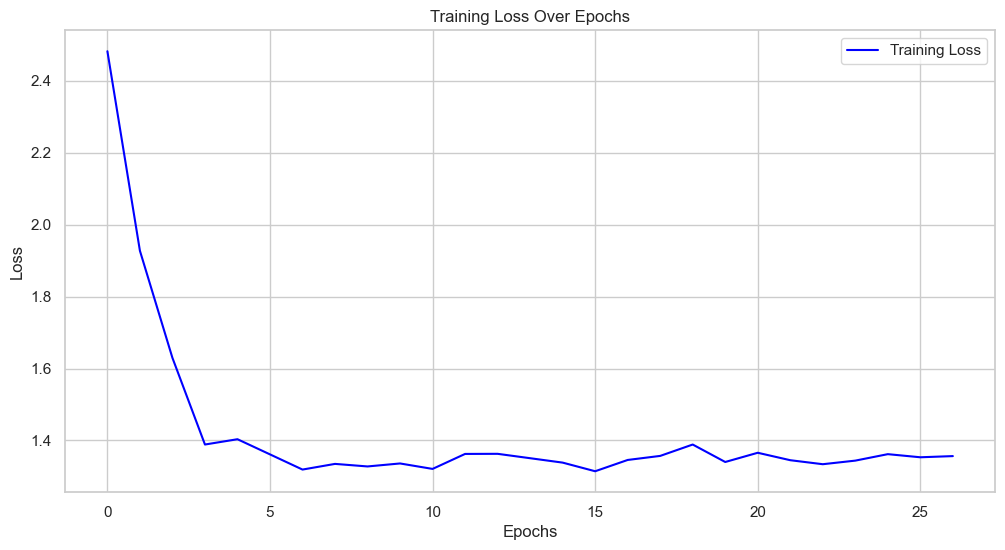

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

loss_curve_nn1 = best_clf_nn1.named_steps['mlp'].loss_curve_

sns.set(style="whitegrid")

# Example of customizing the training loss plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(loss_curve_nn1)), y=loss_curve_nn1, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

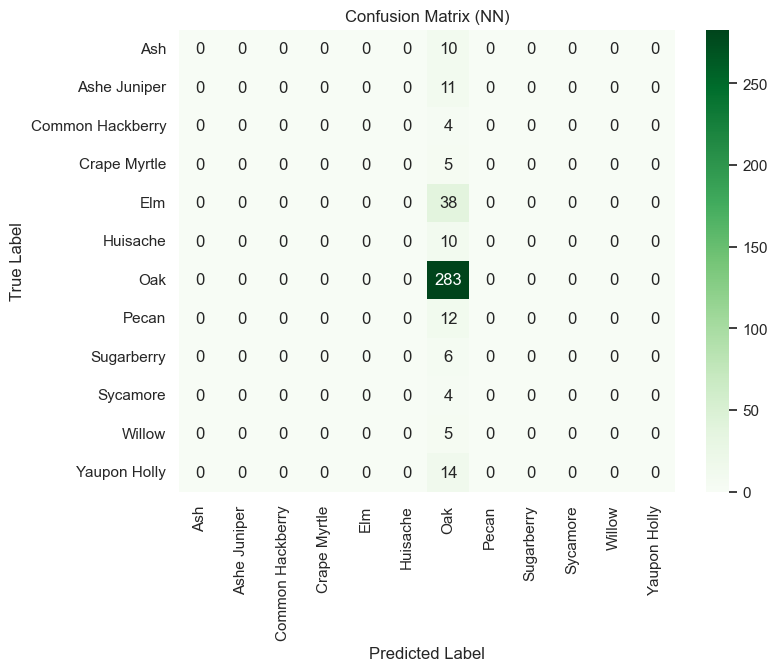

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mapping_dict = dict(sorted(zip(data['BestTreeSpecies_encoded'], data['BestTreeSpecies'])))


y_val_nn1_decoded = [mapping_dict[label] for label in y_val]
y_pred_nn1_decoded = [mapping_dict[label] for label in best_clf_nn1.predict(X_val)]

# Step 4: Calculate the confusion matrix
cm = confusion_matrix(y_val_nn1_decoded, y_pred_nn1_decoded, labels=list(mapping_dict.values()))

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=True,
    xticklabels=list(mapping_dict.values()),
    yticklabels=list(mapping_dict.values())
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (NN)')
plt.savefig('./plots/confusion_matrix_nn.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# Function to create the Keras model
def create_keras_model(hidden_layer_sizes, activation, alpha, num_classes):
    model = Sequential()
    for units in hidden_layer_sizes:
        model.add(Dense(units=units, activation=activation, kernel_regularizer='l2'))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multiclass
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical crossentropy
    return model

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Convert labels to one-hot encoding if not already done
num_classes = 29  # Assuming y_train contains all classes
y_resampled_one_hot = to_categorical(y_resampled, num_classes=num_classes)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Define the model parameters
hidden_layer_sizes = (128, 64, 32, 16, 8)
activation = 'relu'
alpha = 0.01
epochs = 100
batch_size = 32

# Create and fit the Keras model
model = create_keras_model(hidden_layer_sizes, activation, alpha, num_classes)

# Fit the model with sample weights
history = model.fit(X_train, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    sample_weight=sample_weights,
                    verbose=3)

# Evaluate on training data
y_train_pred = model.predict(X_train)
y_train_pred_classes = y_train_pred.argmax(axis=1)  # Get class predictions
accuracy_train = accuracy_score(y_train, y_train_pred_classes)
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Evaluate on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = y_val_pred.argmax(axis=1)  # Get class predictions
accuracy_val = accuracy_score(y_val, y_val_pred_classes)
print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")

# Evaluate on test data
y_test_pred = model.predict(X_test)
y_test_pred_classes = y_test_pred.argmax(axis=1)  # Get class predictions
accuracy_test = accuracy_score(y_test, y_test_pred_classes)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [25]:
pd.Series(y_train_pred).unique()

array([1.], dtype=float32)

In [28]:
print("Number of unique classes in y_train:", len(set(y_train)))
print("Number of unique classes in y_val:", len(set(y_val)))
print("Number of unique classes in y_test:", len(set(y_test)))


Number of unique classes in y_train: 12
Number of unique classes in y_val: 12
Number of unique classes in y_test: 12


In [39]:
to_categorical(y_train, 28)

IndexError: index 28 is out of bounds for axis 1 with size 28